 # Análise e classificação dos insultos de Donald Trump no Twitter

 **Autor:** Wesley Lima de Araujo  
 **RA:**11201721514

Nesse projeto será realizada uma breve análise exploratória e de sentimento de um [dataset do kaggle]( https://www.kaggle.com/ayushggarg/all-trumps-twitter-insults-20152021) que contém tweets do ex-presidente americano Donald Trump que ofendem diretamente alguém. As análises exploratória e de sentimento serão breves, pois o principal objetivo do projeto é construir alguns modelos que sejam capazes de classificar quem foi insultado pelo tweet, e ao final será feita uma comparação entre os modelos. A variável alvo dos modelos será quem foi ofendido por Trump.

Segue um roteiro das etapas do projeto que serão desenvolvidas:
1. Importação das bibliotecas que serão usadas.
2. Importação e tratamento da base de dados.
3. Análise exploratória e de sentimento buscando conhecer melhor a base de dados.
4. Atividades de pré-processamento dos dados textuais.
5. Construção das bases de treino e teste.
6. Criar representação vetorial dos textos.
7. Criação de modelos usando Naive-Bayes, Regressão Logística e Support Vector Machines.
8. Comparação dos modelos criados.

Ao final serão feitas algumas considerações finais.

# 1. Importação das bibliotecas e pacotes

In [63]:
# Importação de bibliotecas e pacotes que serão usados ao longo do notebook
import pandas as pd
import plotly.express as px
import nltk
from textblob import TextBlob
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Importando e tratando a base de dados

Para não termos que usar a API do Kaggle no notebook, pois precisa de token pessoal, fiz upload da base de dados no meu github pessoal. Assim, basta realizar um wget para pegar os dados em csv do github.

In [2]:
# Baixando os dados do github
!wget https://raw.githubusercontent.com/WLAraujo/python_PLN/main/AP03_classificacao_analise_trump_tweets/trump_insult_tweets_2014_to_2021.csv

--2021-11-21 05:26:30--  https://raw.githubusercontent.com/WLAraujo/python_PLN/main/AP03_classificacao_analise_trump_tweets/trump_insult_tweets_2014_to_2021.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2810219 (2.7M) [text/plain]
Saving to: ‘trump_insult_tweets_2014_to_2021.csv.2’

trump_insult_tweets 100%[===================>]   2.68M  --.-KB/s    in 0.02s   

2021-11-21 05:26:31 (152 MB/s) - ‘trump_insult_tweets_2014_to_2021.csv.2’ saved [2810219/2810219]



Sobre a base de dados, o autor original das informações contidas foi o [The New York times](https://www.nytimes.com/interactive/2021/01/19/upshot/trump-complete-insult-list.html#), o usuário do Kaggle que realizou seu upload só a organizou de maneira tabelada. Os tweets vão de 2014 até 2021 e não contam com os retweets.

In [3]:
# Criando dataframe a partir do csv
tweets = pd.read_csv('trump_insult_tweets_2014_to_2021.csv')

In [4]:
# Visualizando a head da tabela
tweets.head(10)

,Unnamed: 0,date,target,insult,tweet
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."
5,6,2015-06-24,rockin-in-the-free-world,didn't love it,".@Neilyoung’s song, “Rockin’ In The Free World..."
6,7,2015-06-25,willie-geist,uncomfortable looking,Uncomfortable looking NBC reporter Willie Geis...
7,8,2015-06-25,jeb-bush,will NEVER Make America Great Again,"Just out, the new nationwide @FoxNews poll has..."
8,9,2015-06-25,molly-sims,a disaster,The ratings for The View are really low. Nicol...
9,10,2015-06-25,nicole-wallace,a disaster,The ratings for The View are really low. Nicol...


**Dicionário de dados:**
* 'Unnamed: 0' - Índice original da tabela.
* 'date' - Data em que o tweet foi realizado.
* 'target' - Quem foi o alvo da ofensa contida no tweet.
* 'insult' - Qual foi o insulto proferido no tweet.
* 'tweet' - Tweet completo.

In [5]:
# Vamos remover a coluna 'Unnamed 0', usada originalmente como índice da tabela
tweets = tweets.drop(columns='Unnamed: 0')

Veja que podemos ter várias linhas com o mesmo tweet, pois, como o foco é encontrar os insultos, podemos ter mais de um 'insult' para o mesmo 'tweet'.  Por isso, vamos começar realizando um agrupamento dos dados por 'tweet', 'target' e 'date'.

In [6]:
# Realizando agrupamento de 'tweet' e 'target'
tweets_agrupados = tweets[['target','tweet', 'date']].drop_duplicates().reset_index()
tweets_agrupados

,index,target,tweet,date
0,0,thomas-frieden,"Can you believe this fool, Dr. Thomas Frieden ...",2014-10-09
1,2,politicians,Big time in U.S. today - MAKE AMERICA GREAT AG...,2015-06-16
2,3,ben-cardin,Politician @SenatorCardin didn't like that I s...,2015-06-24
3,4,neil-young,"For the nonbeliever, here is a photo of @Neily...",2015-06-24
4,5,rockin-in-the-free-world,".@Neilyoung’s song, “Rockin’ In The Free World...",2015-06-24
...,...,...,...,...
7116,10355,2020-election,If Vice President @Mike_Pence comes through fo...,2021-01-06
7117,10356,2020-election,"States want to correct their votes, which they...",2021-01-06
7118,10357,2020-election,"They just happened to find 50,000 ballots late...",2021-01-06
7119,10358,2020-election,The States want to redo their votes. They foun...,2021-01-06


In [7]:
# Vamos dropar os índices antigos
tweets_agrupados = tweets_agrupados.drop(columns='index')

Essa é uma base de dados muito interessante e com potencial de gerar um bom projeto, mas vou mostrar um problema indesejável quando vamos fazer um projeto de aprendizado de máquina envolvendo classificação.

In [8]:
# Primeiro vamos ver a quantidade de linhas que a base possui
tweets_agrupados.shape

(7121, 3)

In [9]:
# Vamos ver a quantidade de classes que a coluna 'target' possui
len(tweets_agrupados['target'].unique())

867

Isso significa que teriamos 867 classes para 7113 linhas disponíveis para realizar treino e teste, o que pode ser considerado inviável para realizar o treinamento de modelo de classificação que desejamos, já que, muito provavelmente, teríamos um problema de desbalanceamento de classes. Para contornar essa situação vamos pegar na base apenas as 10 classes da coluna 'target' com mais linhas na base de dados.

In [10]:
# Verificando quais são as classes que atendem o critério target com mais linhas
top_10 = tweets_agrupados.groupby(['target']).count().nlargest(10, 'tweet').drop(columns='date')
top_10

,tweet
target,
the-media,828
democrats,502
hillary-clinton,473
trump-russia,319
joe-biden,294
impeachment-inquiry,208
the-new-york-times,206
cnn,177
2020-election,135


In [11]:
# Vendo quantas linhas a nova base terá
top_10['tweet'].sum()

3253

In [12]:
# Criando nova base de tweets com apenas essas classes
tweets_10 = tweets_agrupados.loc[tweets_agrupados['target'].isin(list(top_10.index))].reset_index().drop(columns='index')
tweets_10.head(10)

,target,tweet,date
0,cnn,Ratings starved @CNN and @CNNPolitics does not...,2015-07-18
1,cnn,The $10 billion (net worth) is AFTER all debt ...,2015-07-18
2,the-media,I truly LOVE all of the millions of people who...,2015-07-29
3,the-new-york-times,Despite the false @nytimes story about Jeb Bus...,2015-08-03
4,hillary-clinton,"Hillary said such nasty things about me, read ...",2015-09-05
5,hillary-clinton,Remember that I am self-funding my campaign. H...,2015-09-05
6,the-media,"I am attracting the biggest crowds, by far, an...",2015-09-21
7,the-media,Despite the establishment and the media’s best...,2015-09-24
8,the-media,I'm leading by big margins in every poll but t...,2015-10-04
9,hillary-clinton,"The trade deal is a disaster, she was always f...",2015-10-14


# 3. Análise exploratória e de sentimento da base

In [13]:
# Vamos começar realizando um agrupamento por ano para ver como esses dados comportaram-se ao longo dos anos
# Vamos aproveitar e tentar ver quantas vezes cada 'target' foi alvo ao longo de cada ano
tweets_10['year'] = pd.DatetimeIndex(tweets_10['date']).year
fig = px.histogram(tweets_10, x='year', color='target', labels={'year':'Ano', 'y':'Tweets'}, title = 'Tweets por target')
fig.update_layout(bargap=0.2, yaxis_title_text='Contagem')
fig.show()

Perceba que temos a informação de que no tweet em questão está contida uma ofensa, porém, não temos a noção de polarização de maneira direta, ou seja, não sabemos de maneira numérica o quanto cada tweet foi ofensivo/negativo. Vamos usar a TextBlob para calcular uma coluna nova no dataframe que vai conter a polaridade de cada tweet. Com esse dado novo podemos ver qual foi o 'target' mais ofendido por outra métrica a não ser a quantidade de tweets.

In [14]:
# Vamos calcular a nova coluna usando a chave 'polarity' do atributo 'sentiment' da TextBlob 
polarity = []
for tweet in tweets_10['tweet']:
  texto = tweet
  obj = TextBlob(texto)
  polarity.append(obj.sentiment.polarity)
tweets_10['polarity'] = polarity
tweets_10.head(10)

,target,tweet,date,year,polarity
0,cnn,Ratings starved @CNN and @CNNPolitics does not...,2015-07-18,2015,0.055283
1,cnn,The $10 billion (net worth) is AFTER all debt ...,2015-07-18,2015,-0.076607
2,the-media,I truly LOVE all of the millions of people who...,2015-07-29,2015,0.450000
3,the-new-york-times,Despite the false @nytimes story about Jeb Bus...,2015-08-03,2015,-0.025000
4,hillary-clinton,"Hillary said such nasty things about me, read ...",2015-09-05,2015,-0.291667
5,hillary-clinton,Remember that I am self-funding my campaign. H...,2015-09-05,2015,0.357143
6,the-media,"I am attracting the biggest crowds, by far, an...",2015-09-21,2015,0.079167
7,the-media,Despite the establishment and the media’s best...,2015-09-24,2015,0.487500
8,the-media,I'm leading by big margins in every poll but t...,2015-10-04,2015,0.500000
9,hillary-clinton,"The trade deal is a disaster, she was always f...",2015-10-14,2015,0.000000


In [15]:
# Visualizando a polaridade média para cada 'target'
fig = px.histogram(tweets_10, x='target', y = 'polarity', color='target', histfunc='avg', labels={'target':'Target'})
fig.update_layout(bargap=0.2, yaxis_title_text='Média da polaridade')
fig.show()

No gráfico acima vemos um resultado surpreendente. Os índices de polarização para a maioria dos 'target' é próximo a zero, mas, como trata-se de um dataset exclusivamente de insultos, era esperado que os valores de polaridade ficassem mais baixos. Existem dois comportamentos que foram percebidos nos tweets de Trump que podem ser explicativos para os valores duvidosos obtidos pela TextBlob.

O primeiro comportamento é que Trump costuma se vangloriar no mesmo tweet que ataca seus adversários, então muitos tweets acabam possuindo palavras com valor positivo, o que atrapalha o cálculo de polaridade. O outro comportamento percebido é que Trump usa muito de ironia em seus tweets, o que é difícil de qualquer modelo perceber e também acaba contando para uma polaridade mais positiva quando o tweet em si é negativo.

Com essa breve análise exploratória e de sentimentos dos dados encerramos essa parte do projeto.

# 4. Pré-processamento

No nosso pré-processamento realizaremos os seguintes processos:
1. Tokenização dos tweets.
2. Remoção de pontuação dos tweets.
3. Conversão de todas as letras para minúsculo.
4. Remoção das stopwords dos tweets.
5. Stemmização dos tweets.



In [16]:
# Definindo função de limpeza que realizará todos os processos citados acima
# A função devolverá duas listas que serão adicionada ao dataframe como colunas
def limpeza_tweets(tweet):
  # Tokenização e remoção de pontuação
  blob = TextBlob(tweet)
  tokens = list(blob.words)
  # Conversão para minúsculo
  tokens = [token.lower() for token in tokens]
  # Remoção de stopwords
  sws = stopwords.words('english')
  tokens = [token for token in tokens if token not in sws]
  # Stemming dos tokens
  stm = PorterStemmer()
  stems = [stm.stem(word = token) for token in tokens]
  # Retornando tokens
  return tokens, stems

In [17]:
# Criando colunas de tokens e stems no nosso dataframe
tokens_stems = [limpeza_tweets(tweet) for tweet in tweets_10['tweet']]
tokens = [tokens_stems[i][0] for i in range(len(tokens_stems))]
stems = [tokens_stems[i][1] for i in range(len(tokens_stems))]
tweets_10['tokens'] = tokens
tweets_10['stems'] = stems
tweets_10.head(10)

,target,tweet,date,year,polarity,tokens,stems
0,cnn,Ratings starved @CNN and @CNNPolitics does not...,2015-07-18,2015,0.055283,"[ratings, starved, cnn, cnnpolitics, cover, ac...","[rate, starv, cnn, cnnpolit, cover, accur, ca,..."
1,cnn,The $10 billion (net worth) is AFTER all debt ...,2015-07-18,2015,-0.076607,"[10, billion, net, worth, debt, liabilities, s...","[10, billion, net, worth, debt, liabil, simpl,..."
2,the-media,I truly LOVE all of the millions of people who...,2015-07-29,2015,0.450000,"[truly, love, millions, people, sticking, desp...","[truli, love, million, peopl, stick, despit, m..."
3,the-new-york-times,Despite the false @nytimes story about Jeb Bus...,2015-08-03,2015,-0.025000,"[despite, false, nytimes, story, jeb, bush, ha...","[despit, fals, nytim, stori, jeb, bush, happi,..."
4,hillary-clinton,"Hillary said such nasty things about me, read ...",2015-09-05,2015,-0.291667,"[hillary, said, nasty, things, read, directly,...","[hillari, said, nasti, thing, read, directli, ..."
5,hillary-clinton,Remember that I am self-funding my campaign. H...,2015-09-05,2015,0.357143,"[remember, self-funding, campaign, hillary, je...","[rememb, self-fund, campaign, hillari, jeb, re..."
6,the-media,"I am attracting the biggest crowds, by far, an...",2015-09-21,2015,0.079167,"[attracting, biggest, crowds, far, best, poll,...","[attract, biggest, crowd, far, best, poll, num..."
7,the-media,Despite the establishment and the media’s best...,2015-09-24,2015,0.487500,"[despite, establishment, media, ’, best, effor...","[despit, establish, media, ’, best, effort, pe..."
8,the-media,I'm leading by big margins in every poll but t...,2015-10-04,2015,0.500000,"['m, leading, big, margins, every, poll, press...","['m, lead, big, margin, everi, poll, press, ke..."
9,hillary-clinton,"The trade deal is a disaster, she was always f...",2015-10-14,2015,0.000000,"[trade, deal, disaster, always, demdebate]","[trade, deal, disast, alway, demdeb]"


Adicionamos as duas colunas porque vamos comparar a diferença de performance quando o modelo treina com stemming e quando o modelo treina com os tokens.

# 5. Divisão treino-teste dos dados

In [18]:
# Para a divisão treino-teste vamos usar um split de 75-25
tweets_treino, tweets_teste = train_test_split(tweets_10, test_size=0.25, random_state=2)

In [19]:
# Visualizando as dimensões de ambas as novas tabelas
print(tweets_treino.shape)
print(tweets_teste.shape)

(2439, 7)
(814, 7)


# 6. Criando representação dos textos através de Matriz Termo Documento

In [90]:
# Criando objeto vetorizador para Matriz Termo Documento
vetorizador_tokens = CountVectorizer()
vetorizador_stems = CountVectorizer()

In [91]:
# Criando representação para tokens puros sem stemming
tokens_treino = vetorizador_tokens.fit_transform([" ".join(tokens) for tokens in tweets_treino['tokens']])
tokens_teste = vetorizador_tokens.transform([" ".join(tokens) for tokens in tweets_teste['tokens']])

In [92]:
# Criando representação para stems
stems_treino = vetorizador_stems.fit_transform([" ".join(stems) for stems in tweets_treino['stems']])
stems_teste = vetorizador_stems.transform([" ".join(stems) for stems in tweets_teste['stems']])

# 7. Criando os modelos NB, RegLog e SVM

In [98]:
# Criando os modelos
# Estamos usando o toarray() em alguns modelos para realizar a conversão de matriz esparsa para densa
modelo_svm_tokens = LinearSVC().fit(tokens_treino,tweets_treino['target'])
modelo_reglog_tokens = LogisticRegression().fit(tokens_treino,tweets_treino['target'])
modelo_nb_tokens = GaussianNB().fit(tokens_treino.toarray(),tweets_treino['target'])
modelo_svm_stems = LinearSVC().fit(stems_treino.toarray(),tweets_treino['target'])
modelo_reglog_stems = LogisticRegression().fit(stems_treino.toarray(),tweets_treino['target'])
modelo_nb_stems = GaussianNB().fit(stems_treino.toarray(),tweets_treino['target'])

# 8. Avaliando os modelos por métricas

**Dicionário de Labels:**
1. 2020-election
2. adam-schiff
3. cnn
4. democrats
5. hilary-clinton
6. impeachment-inquiry
7. joe-biden
8. the-media
9. the-new-york-times
10. trump-russia

## 8.1 Modelos SVM

                     precision    recall  f1-score   support

      2020-election       0.83      0.85      0.84        40
        adam-schiff       0.89      0.57      0.69        30
                cnn       0.82      0.77      0.80        48
          democrats       0.79      0.72      0.75       113
    hillary-clinton       0.82      0.85      0.84       108
impeachment-inquiry       0.51      0.54      0.52        52
          joe-biden       0.85      0.83      0.84        83
          the-media       0.72      0.81      0.76       194
 the-new-york-times       0.77      0.86      0.82        59
       trump-russia       0.68      0.57      0.62        87

           accuracy                           0.76       814
          macro avg       0.77      0.74      0.75       814
       weighted avg       0.76      0.76      0.76       814



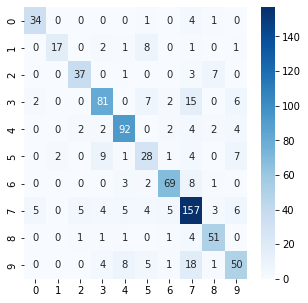

In [97]:
# Modelo SVM para tokens
previsoes_target = modelo_svm_tokens.predict(tokens_teste)
cm = confusion_matrix(tweets_teste['target'], previsoes_target)
figure(figsize=(5, 5))
sns.heatmap(cm, annot=True,cmap="Blues",fmt="d")
print(classification_report(tweets_teste['target'], previsoes_target))

                     precision    recall  f1-score   support

      2020-election       0.85      0.82      0.84        40
        adam-schiff       0.84      0.53      0.65        30
                cnn       0.83      0.73      0.78        48
          democrats       0.70      0.71      0.70       113
    hillary-clinton       0.80      0.82      0.81       108
impeachment-inquiry       0.50      0.48      0.49        52
          joe-biden       0.81      0.82      0.81        83
          the-media       0.71      0.79      0.75       194
 the-new-york-times       0.72      0.81      0.76        59
       trump-russia       0.67      0.54      0.60        87

           accuracy                           0.73       814
          macro avg       0.74      0.71      0.72       814
       weighted avg       0.73      0.73      0.73       814



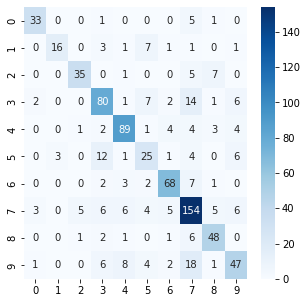

In [100]:
# Modelo SVM para stems
previsoes_target = modelo_svm_stems.predict(stems_teste.toarray())
cm = confusion_matrix(tweets_teste['target'], previsoes_target)
figure(figsize=(5, 5))
sns.heatmap(cm, annot=True,cmap="Blues",fmt="d")
print(classification_report(tweets_teste['target'], previsoes_target))

## 8.2 Modelos NB

                     precision    recall  f1-score   support

      2020-election       0.73      0.20      0.31        40
        adam-schiff       0.15      0.13      0.14        30
                cnn       0.29      0.19      0.23        48
          democrats       0.34      0.48      0.40       113
    hillary-clinton       0.53      0.43      0.47       108
impeachment-inquiry       0.29      0.23      0.26        52
          joe-biden       0.42      0.33      0.36        83
          the-media       0.33      0.46      0.38       194
 the-new-york-times       0.44      0.29      0.35        59
       trump-russia       0.32      0.31      0.31        87

           accuracy                           0.36       814
          macro avg       0.38      0.30      0.32       814
       weighted avg       0.38      0.36      0.36       814



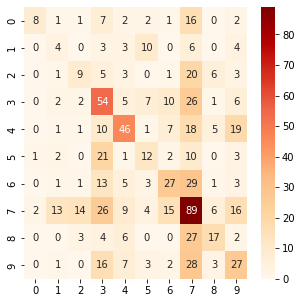

In [102]:
# Modelo NB para tokens
previsoes_target = modelo_nb_tokens.predict(tokens_teste.toarray())
cm = confusion_matrix(tweets_teste['target'], previsoes_target)
figure(figsize=(5, 5))
sns.heatmap(cm, annot=True,cmap="OrRd",fmt="d")
print(classification_report(tweets_teste['target'], previsoes_target))

                     precision    recall  f1-score   support

      2020-election       0.71      0.25      0.37        40
        adam-schiff       0.13      0.13      0.13        30
                cnn       0.26      0.19      0.22        48
          democrats       0.33      0.40      0.36       113
    hillary-clinton       0.42      0.39      0.41       108
impeachment-inquiry       0.26      0.29      0.27        52
          joe-biden       0.36      0.33      0.34        83
          the-media       0.31      0.39      0.35       194
 the-new-york-times       0.34      0.20      0.26        59
       trump-russia       0.27      0.26      0.27        87

           accuracy                           0.32       814
          macro avg       0.34      0.28      0.30       814
       weighted avg       0.34      0.32      0.32       814



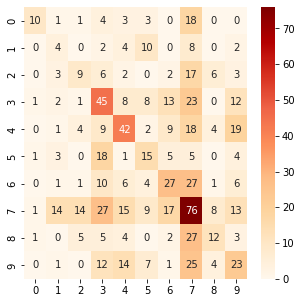

In [67]:
# Modelo NB para stems
previsoes_target = modelo_nb_stems.predict(stems_teste.toarray())
cm = confusion_matrix(tweets_teste['target'], previsoes_target)
figure(figsize=(5, 5))
sns.heatmap(cm, annot=True,cmap="OrRd",fmt="d")
print(classification_report(tweets_teste['target'], previsoes_target))

## 8.3 Modelos RegLog

                     precision    recall  f1-score   support

      2020-election       0.94      0.85      0.89        40
        adam-schiff       0.89      0.57      0.69        30
                cnn       0.80      0.77      0.79        48
          democrats       0.81      0.77      0.79       113
    hillary-clinton       0.81      0.84      0.83       108
impeachment-inquiry       0.53      0.54      0.53        52
          joe-biden       0.86      0.83      0.85        83
          the-media       0.72      0.84      0.77       194
 the-new-york-times       0.78      0.78      0.78        59
       trump-russia       0.70      0.61      0.65        87

           accuracy                           0.77       814
          macro avg       0.78      0.74      0.76       814
       weighted avg       0.77      0.77      0.77       814



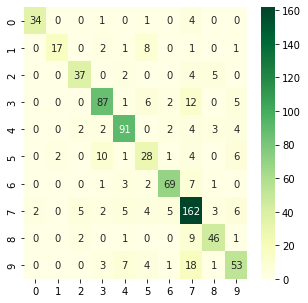

In [104]:
# Modelo RegLog para tokens
previsoes_target = modelo_reglog_tokens.predict(tokens_teste.toarray())
cm = confusion_matrix(tweets_teste['target'], previsoes_target)
figure(figsize=(5, 5))
sns.heatmap(cm, annot=True,cmap="YlGn",fmt="d")
print(classification_report(tweets_teste['target'], previsoes_target))

                     precision    recall  f1-score   support

      2020-election       0.92      0.82      0.87        40
        adam-schiff       0.85      0.57      0.68        30
                cnn       0.82      0.75      0.78        48
          democrats       0.75      0.74      0.75       113
    hillary-clinton       0.80      0.83      0.82       108
impeachment-inquiry       0.50      0.52      0.51        52
          joe-biden       0.86      0.83      0.85        83
          the-media       0.71      0.84      0.77       194
 the-new-york-times       0.80      0.80      0.80        59
       trump-russia       0.69      0.55      0.61        87

           accuracy                           0.75       814
          macro avg       0.77      0.73      0.74       814
       weighted avg       0.76      0.75      0.75       814



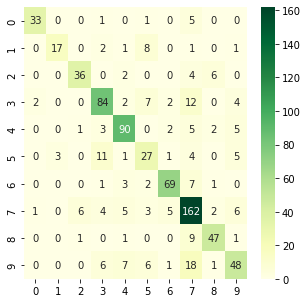

In [68]:
# Modelo RegLog para stems
previsoes_target = modelo_reglog_stems.predict(stems_teste.toarray())
cm = confusion_matrix(tweets_teste['target'], previsoes_target)
figure(figsize=(5, 5))
sns.heatmap(cm, annot=True,cmap="YlGn",fmt="d")
print(classification_report(tweets_teste['target'], previsoes_target))

# Considerações Finais

Esse projeto foi desenvolvido com os objetivos de apresentar uma breve análise de sentimento e de construir e comparar distintos modelos de classificação de texto. O uso da ferramenta TextBlob permitiu realizar uma análise de sentimento básica através da quantificação da polarização dos tweets ofensivos de Donald Trump, isso permitiu a observação de um comportamento anormal dos valores e de possíveis hipóteses para explicá-lo. Sobre os modelos de classificação, foi possível construir 6 deles, usando três algoritmos e duas formas de representação diferentes dos tweets para treino. Na parte dos modelos foi possível perceber que os dois modelos de Naive Bayes apresentaram resultados piores que os dos outros algoritmos. Já os modelos de Regressão Logística e SVM apresentaram desempenhos equiparáveis, embora RegLog tenha apresentado desempenho melhor para mais classes.
